# OpenMDAO components to modify a mesh, the classes of the geometry_mesh_transformation file :

This notebook was created to  : 

$\rightarrow{}$ understand the classes of the file geometry_mesh_transformation which allow to modify a mesh. 

$\rightarrow{}$ show how to use the new class implemted in geometry_mesh_tranformation : Dihedral_distrib.


Summary of the things done in this notebook :

1/ We make the imports and define a plotmesh function.

2/ We define a simple mesh that we will manipulate.

3/ We modify the mesh using the class ScaleX and plot the result.

4/ a/ We modify the mesh using the class ShearX and plot the result. b/ We modify the mesh using the class ShearZ and plot the result.

5/ We modify the mesh by using the class Dihedral and plot the result.

6/ We modify the mesh by using the class Rotate and plot the result.

7/ Implementation of the new Dihedral_distrib class in order to be able to have diferrent dihedral angles for the panels of the wing and not only one for all the wing. 

$\rightarrow{}$ Test the class modifying the mesh.

$\rightarrow{}$ Check the partial derivatives coputed

1/ and 2/ :

Unable to import mpi4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.
[[[ 0.4 -2.   0. ]
  [ 0.2 -1.   0. ]
  [ 0.1 -0.5  0. ]
  [ 0.   0.   0. ]
  [ 0.1  0.5  0. ]
  [ 0.2  1.   0. ]
  [ 0.4  2.   0. ]]

 [[ 0.9 -2.   0. ]
  [ 0.7 -1.   0. ]
  [ 0.6 -0.5  0. ]
  [ 0.5  0.   0. ]
  [ 0.6  0.5  0. ]
  [ 0.7  1.   0. ]
  [ 0.9  2.   0. ]]]


<IPython.core.display.Javascript object>


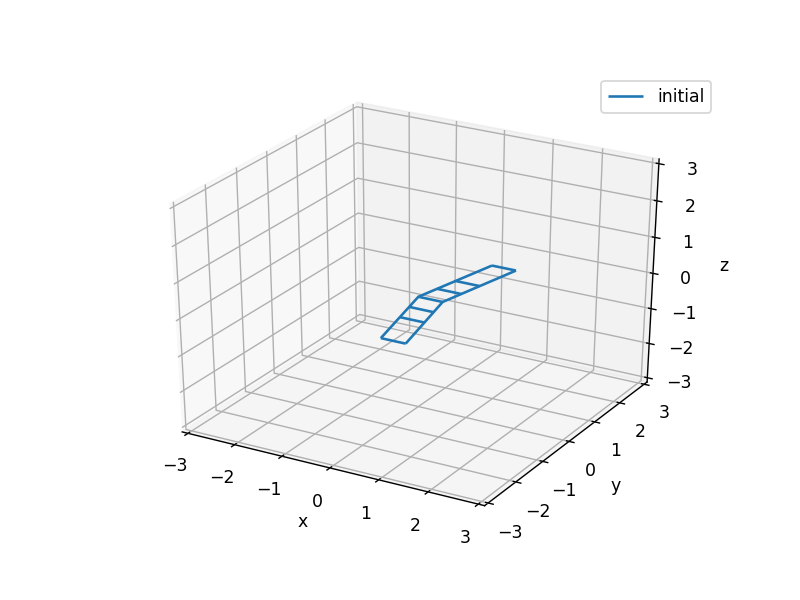

D:\rcharayr\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from openaerostruct.geometry.utils import gen_custom_mesh
%matplotlib notebook
import openmdao.api as om

"""A function to plot a mesh
n_mesh = 1 : only one mesh needs to be ploted
n_mesh > 1 : mesh is a list of meshes, we plot all the meshes on the same figure
"""
def plotmesh(mesh, n_mesh=1): 
    %matplotlib qt
    
    maxi_ax = 0
    for i in range(n_mesh):
        maxi_ax = max([np.max(mesh[i]), maxi_ax])
    #print(maxi_ax)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    if(n_mesh == 1):
        ax.plot_wireframe(mesh[:,:,0], mesh[:,:,1], mesh[:,:,2],rstride=1,cstride=1, label = 'initial') 
    else:
        for i in range(n_mesh):
            ax.plot_wireframe(mesh[i][:,:,0], mesh[i][:,:,1], mesh[i][:,:,2],rstride=1,cstride=1, label = 'initial') 
        
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    #ax.set_xlim(-(1+ np.max(mesh)),(1+ np.max(mesh))) # à commenter pour mieux voir le twist ou le dihèdre
    #ax.set_ylim(-(1+ np.max(mesh)),(1+ np.max(mesh))) # à commenter pour mieux voir le twist ou le dihèdre
    #ax.set_zlim(-(1+ np.max(mesh)),(1+ np.max(mesh))) # à commenter pour mieux voir le twist ou le dihèdre
    
    ax.set_xlim(-(1+ maxi_ax),(1+ maxi_ax)) # à commenter pour mieux voir le twist ou le dihèdre
    ax.set_ylim(-(1+ maxi_ax),(1+ maxi_ax)) # à commenter pour mieux voir le twist ou le dihèdre
    ax.set_zlim(-(1+ maxi_ax),(1+ maxi_ax)) # à commenter pour mieux voir le twist ou le dihèdre
    ax.legend(loc=0)
    plt.show()

###############################################################################

# instanciate mesh
mesh =  np.zeros((2,7,3))

# define mesh
mesh[:,:,2] = np.zeros((2,7))
mesh[0,:,1] = mesh[1,:,1] = np.array([-2, -1, -0.5, 0.0, 0.5, 1, 2]) 
for i in range(np.shape(mesh)[0]):
    mesh[i,:,0] = np.abs(mesh[0,:,1])*0.2 + i*np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
            
print(mesh)
plotmesh(mesh)

# instanciate mesh_sym 
mesh_sym = mesh[:, :int((np.shape(mesh)[1]+1)/2), :]


3/ (Scalex permet de choisir la longeur de corde à chaque noeud dans la spanwise direction) :

In [2]:
class ScaleX(om.ExplicitComponent):
    """
    OpenMDAO component that manipulates the mesh by modifying the chords along the span of the
    wing by scaling only the x-coord.

    Parameters
    ----------
    mesh[nx, ny, 3] : numpy array
        Nodal mesh defining the initial aerodynamic surface.
    chord[ny] : numpy array
        Chord length for each panel edge.

    Returns
    -------
    mesh[nx, ny, 3] : numpy array
        Nodal mesh with the new chord lengths.
    """

    def initialize(self):
        """
        Declare options.
        """
        self.options.declare('val', desc='Initial value for chord lengths')
        self.options.declare('mesh_shape', desc='Tuple containing mesh shape (nx, ny).')

    def setup(self):
        mesh_shape = self.options['mesh_shape']
        val = self.options['val']

        self.add_input('chord', units='m', val=val)
        self.add_input('in_mesh', shape=mesh_shape, units='m')

        self.add_output('mesh', shape=mesh_shape, units='m')

        nx, ny, _ = mesh_shape
        nn = nx * ny * 3

        rows = np.arange(nn)
        col = np.tile(np.zeros(3), ny) + np.repeat(np.arange(ny), 3)
        cols = np.tile(col, nx)

        self.declare_partials('mesh', 'chord', rows=rows, cols=cols)

        p_rows = np.arange(nn)
        te_rows = np.arange(((nx-1) * ny * 3))
        le_rows = te_rows + ny*3
        le_cols = np.tile(np.arange(3 * ny), nx-1)
        te_cols = le_cols + ny*3*(nx-1)
        rows = np.concatenate([p_rows, te_rows, le_rows])
        cols = np.concatenate([p_rows, te_cols, le_cols])

        self.declare_partials('mesh', 'in_mesh', rows=rows, cols=cols)

    def compute(self, inputs, outputs):
        mesh = inputs['in_mesh']
        chord_dist = inputs['chord']

        te = mesh[-1]
        le = mesh[ 0]
        quarter_chord = 0.25 * te + 0.75 * le

        outputs['mesh'] = np.einsum('ijk,j->ijk', mesh - quarter_chord, chord_dist) + quarter_chord

    def compute_partials(self, inputs, partials):
        mesh = inputs['in_mesh']
        chord_dist = inputs['chord']

        te = mesh[-1]
        le = mesh[ 0]
        quarter_chord = 0.25 * te + 0.75 * le

        partials['mesh', 'chord'] = (mesh - quarter_chord).flatten()

        nx, ny, _ = mesh.shape
        nn = nx * ny * 3
        d_mesh = np.einsum('i,ij->ij', chord_dist, np.ones((ny, 3))).flatten()
        partials['mesh', 'in_mesh'][:nn] = np.tile(d_mesh, nx)

        d_qc = (np.einsum('ij,i->ij', np.ones((ny, 3)), 1.0 - chord_dist)).flatten()
        nnq = (nx-1) * ny * 3
        partials['mesh', 'in_mesh'][nn:nn + nnq] = np.tile(0.25 * d_qc, nx-1)
        partials['mesh', 'in_mesh'][nn + nnq:] = np.tile(0.75 * d_qc, nx-1)

        nnq = ny*3
        partials['mesh', 'in_mesh'][nn - nnq:nn] += 0.25 * d_qc
        partials['mesh', 'in_mesh'][:nnq] += 0.75 * d_qc


[[[ 0.4625 -2.      0.    ]
  [ 0.2    -1.      0.    ]
  [ 0.0375 -0.5     0.    ]
  [-0.125   0.      0.    ]
  [ 0.0375  0.5     0.    ]
  [ 0.2     1.      0.    ]
  [ 0.4625  2.      0.    ]]

 [[ 0.7125 -2.      0.    ]
  [ 0.7    -1.      0.    ]
  [ 0.7875 -0.5     0.    ]
  [ 0.875   0.      0.    ]
  [ 0.7875  0.5     0.    ]
  [ 0.7     1.      0.    ]
  [ 0.7125  2.      0.    ]]]
[[[ 0.4625 -2.      0.    ]
  [ 0.2    -1.      0.    ]
  [ 0.0375 -0.5     0.    ]
  [-0.125   0.      0.    ]
  [ 0.0375  0.5     0.    ]
  [ 0.2     1.      0.    ]
  [ 0.4625  2.      0.    ]]

 [[ 0.7125 -2.      0.    ]
  [ 0.7    -1.      0.    ]
  [ 0.7875 -0.5     0.    ]
  [ 0.875   0.      0.    ]
  [ 0.7875  0.5     0.    ]
  [ 0.7     1.      0.    ]
  [ 0.7125  2.      0.    ]]]


<IPython.core.display.Javascript object>


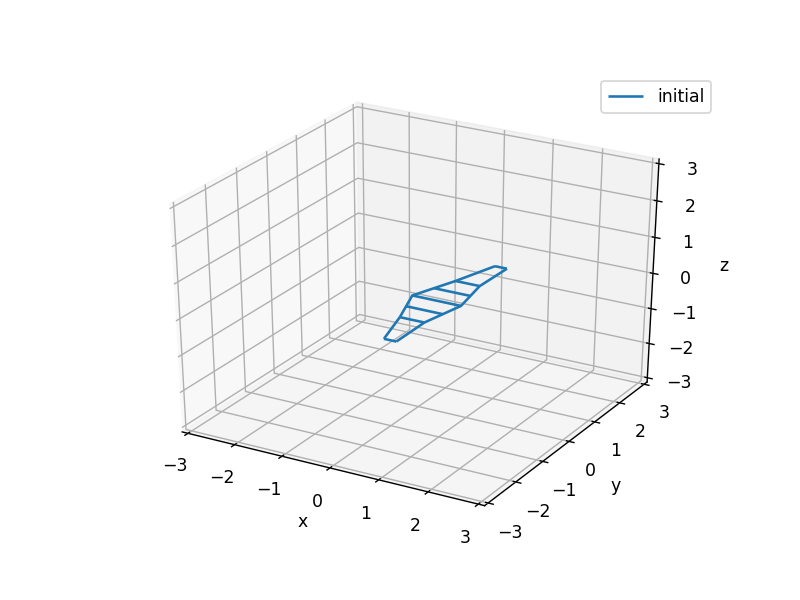

In [12]:
model = om.Group()
model.add_subsystem('ScaleX', ScaleX(val=np.array([0.5, 1, 1.5, 2, 1.5, 1, 0.5]), mesh_shape=np.shape(mesh)))
# We cannot use the symmetry option because it is not declare in this class
#model.add_subsystem('ScaleX', ScaleX(val=np.array([0.5, 1, 1.5, 2]), mesh_shape=np.shape(mesh_sym), symmetry = True))

prob = om.Problem(model)
prob.setup()

prob.set_val('ScaleX.in_mesh', mesh)
# We cannot use the symmetry option because it is not declare in this class
#prob.set_val('ScaleX.in_mesh', mesh_sym)


prob.run_model()
print(prob['ScaleX.mesh'])

print(prob.get_val('ScaleX.mesh'))
plotmesh(prob.get_val('ScaleX.mesh'))

4a/ (Shearx permet de déplacer la corde de chacun des noeuds dans la direction x) :

In [13]:
class ShearX(om.ExplicitComponent):
    """
    OpenMDAO component that manipulates the mesh by shearing the wing in the x direction
    (distributed sweep).

    Parameters
    ----------
    mesh[nx, ny, 3] : numpy array
        Nodal mesh defining the initial aerodynamic surface.
    xshear[ny] : numpy array
        Distance to translate wing in x direction.

    Returns
    -------
    mesh[nx, ny, 3] : numpy array
        Nodal mesh with the new chord lengths.
    """

    def initialize(self):
        """
        Declare options.
        """
        self.options.declare('val', desc='Initial value for x shear.')
        self.options.declare('mesh_shape', desc='Tuple containing mesh shape (nx, ny).')

    def setup(self):
        mesh_shape = self.options['mesh_shape']
        val = self.options['val']

        self.add_input('xshear', val=val, units='m')
        self.add_input('in_mesh', shape=mesh_shape, units='m')

        self.add_output('mesh', shape=mesh_shape, units='m')

        nx, ny, _ = mesh_shape

        nn = nx * ny
        rows = 3.0*np.arange(nn)
        cols = np.tile(np.arange(ny), nx)
        val = np.ones(nn)

        self.declare_partials('mesh', 'xshear', rows=rows, cols=cols, val=val)

        nn = nx * ny * 3
        rows = np.arange(nn)
        cols = np.arange(nn)
        val = np.ones(nn)

        self.declare_partials('mesh', 'in_mesh', rows=rows, cols=cols, val=val)

    def compute(self, inputs, outputs):
        outputs['mesh'][:] = inputs['in_mesh']
        outputs['mesh'][:, :, 0] += inputs['xshear']

[[[ 0.4 -2.   0. ]
  [ 0.7 -1.   0. ]
  [ 0.1 -0.5  0. ]
  [ 0.   0.   0. ]
  [ 0.1  0.5  0. ]
  [ 0.2  1.   0. ]
  [ 0.4  2.   0. ]]

 [[ 0.9 -2.   0. ]
  [ 1.2 -1.   0. ]
  [ 0.6 -0.5  0. ]
  [ 0.5  0.   0. ]
  [ 0.6  0.5  0. ]
  [ 0.7  1.   0. ]
  [ 0.9  2.   0. ]]]
[[[ 0.4 -2.   0. ]
  [ 0.7 -1.   0. ]
  [ 0.1 -0.5  0. ]
  [ 0.   0.   0. ]
  [ 0.1  0.5  0. ]
  [ 0.2  1.   0. ]
  [ 0.4  2.   0. ]]

 [[ 0.9 -2.   0. ]
  [ 1.2 -1.   0. ]
  [ 0.6 -0.5  0. ]
  [ 0.5  0.   0. ]
  [ 0.6  0.5  0. ]
  [ 0.7  1.   0. ]
  [ 0.9  2.   0. ]]]


<IPython.core.display.Javascript object>


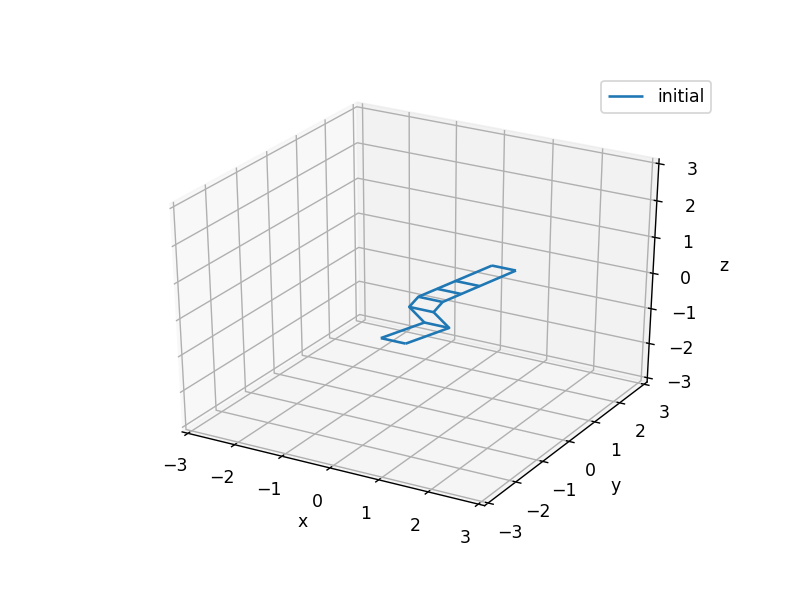

In [14]:
model = om.Group()
model.add_subsystem('ShearX', ShearX(val=np.array([0, 0.5, 0, 0, 0, 0, 0]), mesh_shape=np.shape(mesh)))
# We cannot use the symmetry option because it is not declare in this class
#model.add_subsystem('ShearX', ShearX(val=np.array([0, 0.5, 0, 0]), mesh_shape=np.shape(mesh_sym), symmetry = True))

prob = om.Problem(model)
prob.setup()

prob.set_val('ShearX.in_mesh', mesh)
# We cannot use the symmetry option because it is not declare in this class
#prob.set_val('ShearX.in_mesh', mesh_sym)


prob.run_model()
print(prob['ShearX.mesh'])

print(prob.get_val('ShearX.mesh'))
plotmesh(prob.get_val('ShearX.mesh'))

4a/ (Shearx permet de déplacer la corde de chacun des noeuds dans la direction x, to make winglet for example) :

In [22]:
class ShearZ(om.ExplicitComponent):
    """
    OpenMDAO component that manipulates the mesh by shearing the wing in the z direction
    (distributed sweep).

    Parameters
    ----------
    mesh[nx, ny, 3] : numpy array
        Nodal mesh defining the initial aerodynamic surface.
    zshear[ny] : numpy array
        Distance to translate wing in z direction.

    Returns
    -------
    mesh[nx, ny, 3] : numpy array
        Nodal mesh with the new chord lengths.
    """

    def initialize(self):
        """
        Declare options.
        """
        self.options.declare('val', desc='Initial value for z shear.')
        self.options.declare('mesh_shape', desc='Tuple containing mesh shape (nx, ny).')

    def setup(self):
        mesh_shape = self.options['mesh_shape']
        val = self.options['val']

        self.add_input('zshear', val=val, units='m')
        self.add_input('in_mesh', shape=mesh_shape, units='m')

        self.add_output('mesh', shape=mesh_shape, units='m')

        nx, ny, _ = mesh_shape

        nn = nx * ny
        rows = 3.0*np.arange(nn) + 2
        cols = np.tile(np.arange(ny), nx)
        val = np.ones(nn)

        self.declare_partials('mesh', 'zshear', rows=rows, cols=cols, val=val)

        nn = nx * ny * 3
        rows = np.arange(nn)
        cols = np.arange(nn)
        val = np.ones(nn)

        self.declare_partials('mesh', 'in_mesh', rows=rows, cols=cols, val=val)

    def compute(self, inputs, outputs):
        outputs['mesh'][:] = inputs['in_mesh']
        outputs['mesh'][:, :, 2] += inputs['zshear']

[[[ 0.4 -2.   4. ]
  [ 0.2 -1.   0. ]
  [ 0.1 -0.5  0. ]
  [ 0.   0.   0. ]
  [ 0.1  0.5  0. ]
  [ 0.2  1.   0. ]
  [ 0.4  2.   1. ]]

 [[ 0.9 -2.   4. ]
  [ 0.7 -1.   0. ]
  [ 0.6 -0.5  0. ]
  [ 0.5  0.   0. ]
  [ 0.6  0.5  0. ]
  [ 0.7  1.   0. ]
  [ 0.9  2.   1. ]]]
[[[ 0.4 -2.   4. ]
  [ 0.2 -1.   0. ]
  [ 0.1 -0.5  0. ]
  [ 0.   0.   0. ]
  [ 0.1  0.5  0. ]
  [ 0.2  1.   0. ]
  [ 0.4  2.   1. ]]

 [[ 0.9 -2.   4. ]
  [ 0.7 -1.   0. ]
  [ 0.6 -0.5  0. ]
  [ 0.5  0.   0. ]
  [ 0.6  0.5  0. ]
  [ 0.7  1.   0. ]
  [ 0.9  2.   1. ]]]


<IPython.core.display.Javascript object>


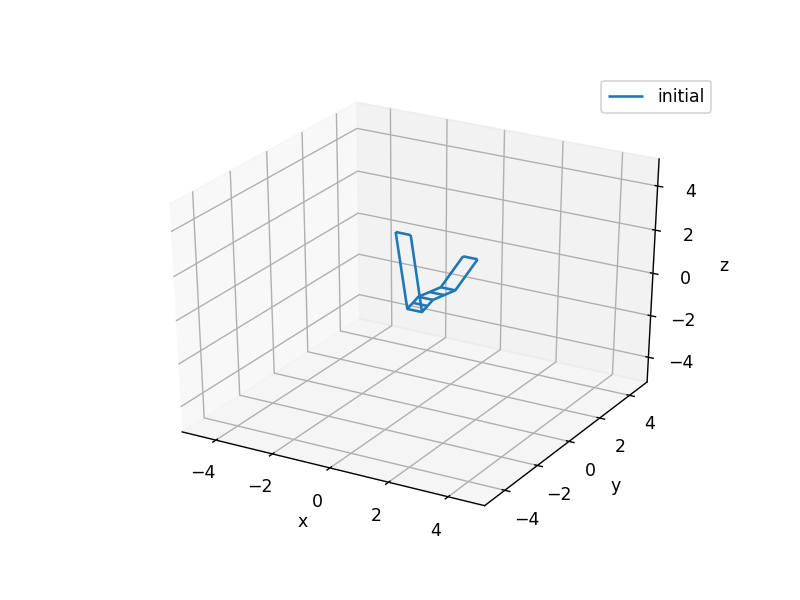

In [24]:
model = om.Group()
model.add_subsystem('ShearZ', ShearZ(val=np.array([4, 0, 0, 0, 0, 0, 1]), mesh_shape=np.shape(mesh)))

prob = om.Problem(model)
prob.setup()

prob.set_val('ShearZ.in_mesh', mesh)

prob.run_model()
print(prob['ShearZ.mesh'])

print(prob.get_val('ShearZ.mesh'))
plotmesh(prob.get_val('ShearZ.mesh'))

5/ (Modify the mesh applying a dihedral angle, note that we can't choose different dihedral angles for the different panels of the wing, we have to choose only one dihedral angle and not a dihedral angle distribution (improvement done in the class Dihedral_distrib $\rightarrow{}$that could allows to make winglet without using Zshear class)) :

In [17]:
class Dihedral(om.ExplicitComponent):
    """
    OpenMDAO component that manipulates the mesh by applying dihedral angle. Positive angles up.

    Parameters
    ----------
    mesh[nx, ny, 3] : numpy array
        Nodal mesh defining the initial aerodynamic surface.
    dihedral : float
        Dihedral angle in degrees.
    symmetry : boolean
        Flag set to true if surface is reflected about y=0 plane.

    Returns
    -------
    mesh[nx, ny, 3] : numpy array
        Nodal mesh defining the aerodynamic surface with dihedral angle.
    """

    def initialize(self):
        """
        Declare options.
        """
        self.options.declare('val', desc='Initial value for dihedral.')
        self.options.declare('mesh_shape', desc='Tuple containing mesh shape (nx, ny).')
        self.options.declare('symmetry', default=False,
                             desc='Flag set to true if surface is reflected about y=0 plane.')

    def setup(self):
        mesh_shape = self.options['mesh_shape']
        val = self.options['val']

        self.add_input('dihedral', val=val, units='deg')
        self.add_input('in_mesh', shape=mesh_shape, units='m')

        self.add_output('mesh', shape=mesh_shape, units='m')

        nx, ny, _ = mesh_shape
        nn = nx*ny
        rows = 3*np.arange(nn) + 2
        cols = np.zeros(nn)

        self.declare_partials('mesh', 'dihedral', rows=rows, cols=cols)

        nn = nx * ny * 3
        n_rows = np.arange(nn)

        if self.options['symmetry']:
            y_cp = ny*3 - 2
            te_cols = np.tile(y_cp, nx * (ny-1))
            te_rows = np.tile(3 * np.arange(ny-1) + 2, nx) + np.repeat(3*ny*np.arange(nx), ny-1)
            se_cols = np.tile(3 * np.arange(ny-1) + 1, nx)
        else:
            y_cp = 3*(ny+1) // 2 - 2
            n_sym = (ny-1) // 2

            te_row = np.tile(3*np.arange(n_sym) + 2, 2) + np.repeat([0, 3*(n_sym+1)], n_sym)
            te_rows = np.tile(te_row, nx) + np.repeat(3*ny*np.arange(nx), ny-1)

            te_col = np.tile(y_cp, n_sym)
            se_col1 = 3*np.arange(n_sym) + 1
            se_col2 = 3*np.arange(n_sym) + 4 + 3*n_sym

            # neat trick: swap columns on reflected side so we can assign in just two operations
            te_cols = np.tile(np.concatenate([te_col, se_col2]), nx)
            se_cols = np.tile(np.concatenate([se_col1, te_col]), nx)

        rows = np.concatenate(([n_rows, te_rows, te_rows]))
        cols = np.concatenate(([n_rows, te_cols, se_cols]))
        print("rows = ", rows)
        print("cols = ", cols)
        
        self.declare_partials('mesh', 'in_mesh', rows=rows, cols=cols)

    def compute(self, inputs, outputs):
        symmetry = self.options['symmetry']
        dihedral_angle = inputs['dihedral'][0]
        mesh = inputs['in_mesh']

        # Get the mesh parameters and desired sweep angle
        nx, ny, _ = mesh.shape
        le = mesh[0]
        p180 = np.pi / 180
        tan_theta = np.tan(p180 * dihedral_angle)

        # If symmetric, simply vary the z-coord based on the distance from the
        # center of the wing
        if symmetry:
            print("symmetry = ", symmetry)
            print("nx = ", nx)
            print("ny = ", ny)
            y0 = le[-1, 1]
            dz = -(le[:, 1] - y0) * tan_theta

        else:
            ny2 = (ny-1) // 2
            y0 = le[ny2, 1]
            dz_right = (le[ny2:, 1] - y0) * tan_theta
            dz_left = -(le[:ny2, 1] - y0) * tan_theta
            dz = np.hstack((dz_left, dz_right))

        # dz added spanwise.
        outputs['mesh'][:] = mesh
        outputs['mesh'][:, :, 2] += dz

    def compute_partials(self, inputs, partials):
        symmetry = self.options['symmetry']
        dihedral_angle = inputs['dihedral'][0]
        mesh = inputs['in_mesh']

        # Get the mesh parameters and desired sweep angle
        nx, ny, _ = mesh.shape
        le = mesh[0]
        p180 = np.pi / 180
        tan_theta = np.tan(p180 * dihedral_angle)
        dtan_dangle = p180 / np.cos(p180*dihedral_angle)**2

        # If symmetric, simply vary the z-coord based on the distance from the
        # center of the wing
        if symmetry:
            y0 = le[-1, 1]
            dz_dtheta = -(le[:, 1] - y0) * dtan_dangle

        else:
            ny2 = (ny-1) // 2
            y0 = le[ny2, 1]
            dz_right = (le[ny2:, 1] - y0) * tan_theta
            dz_left = -(le[:ny2, 1] - y0) * tan_theta

            ddz_right = (le[ny2:, 1] - y0) * dtan_dangle
            ddz_left = -(le[:ny2, 1] - y0) * dtan_dangle
            dz_dtheta = np.hstack((ddz_left, ddz_right))

        # dz added spanwise.
        partials['mesh', 'dihedral'] = np.tile(dz_dtheta, nx)

        nn = nx * ny * 3
        partials['mesh', 'in_mesh'][:nn] = 1.0

        nn2 = nx * (ny-1)
        partials['mesh', 'in_mesh'][nn:nn + nn2] = tan_theta
        partials['mesh', 'in_mesh'][nn + nn2:] = -tan_theta


rows =  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  2  5  8 14 17 20  2  5  8 14 17 20]
cols =  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 10 10 10 10 10 10  1  4  7  1  4  7]
symmetry =  True
nx =  2
ny =  4
[[[ 0.4        -2.          0.35265396]
  [ 0.2        -1.          0.17632698]
  [ 0.1        -0.5         0.08816349]
  [ 0.          0.          0.        ]]

 [[ 0.9        -2.          0.35265396]
  [ 0.7        -1.          0.17632698]
  [ 0.6        -0.5         0.08816349]
  [ 0.5         0.          0.        ]]]
[[[ 0.4        -2.          0.35265396]
  [ 0.2        -1.          0.17632698]
  [ 0.1        -0.5         0.08816349]
  [ 0.          0.          0.        ]]

 [[ 0.9        -2.          0.35265396]
  [ 0.7        -1.          0.17632698]
  [ 0.6        -0.5         0.08816349]
  [ 0.5         0.          0.        ]]]


<IPython.core.display.Javascript object>


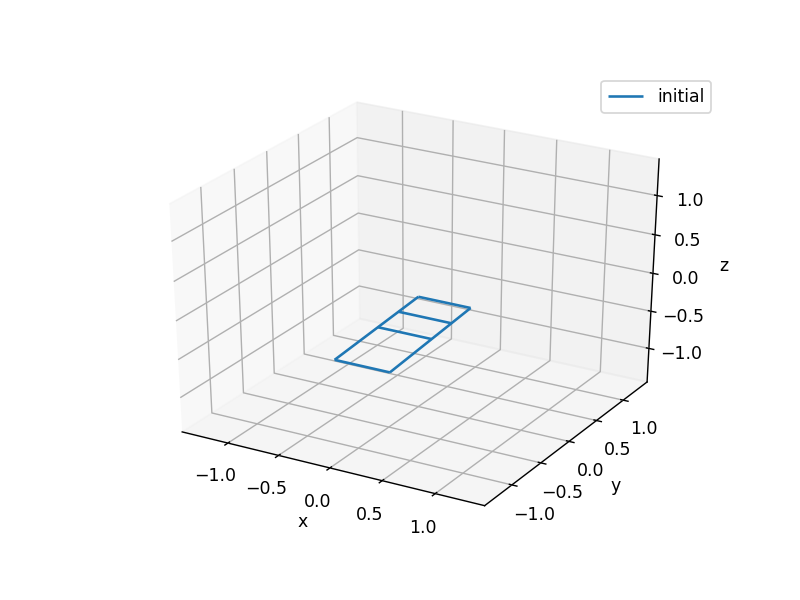

In [18]:
model = om.Group()
#model.add_subsystem('Dihedral', Dihedral(val=10, mesh_shape=np.shape(mesh)))
model.add_subsystem('Dihedral', Dihedral(val=10, mesh_shape=np.shape(mesh_sym), symmetry = True))

prob = om.Problem(model)
prob.setup()

#prob.set_val('Dihedral.in_mesh', mesh)
prob.set_val('Dihedral.in_mesh', mesh_sym)


prob.run_model()
print(prob['Dihedral.mesh'])

print(prob.get_val('Dihedral.mesh'))
plotmesh(prob.get_val('Dihedral.mesh'))


6/ (we can generate wing twist with the Rotate class):

In [19]:
class Rotate(om.ExplicitComponent):
    """
    OpenMDAO component that manipulates the mesh by compute rotation matrices given mesh and
    rotation angles in degrees.

    Parameters
    ----------
    mesh[nx, ny, 3] : numpy array
        Nodal mesh defining the initial aerodynamic surface.
    theta_y[ny] : numpy array
        1-D array of rotation angles about y-axis for each wing slice in degrees.
    symmetry : boolean
        Flag set to True if surface is reflected about y=0 plane.
    rotate_x : boolean
        Flag set to True if the user desires the twist variable to always be
        applied perpendicular to the wing (say, in the case of a winglet).

    Returns
    -------
    mesh[nx, ny, 3] : numpy array
        Nodal mesh defining the twisted aerodynamic surface.
    """

    def initialize(self):
        """
        Declare options.
        """
        # self.options.declare('val', desc='Initial value for dihedral.')
        self.options.declare('val', desc='Initial value for twist.')
        self.options.declare('mesh_shape', desc='Tuple containing mesh shape (nx, ny).')
        self.options.declare('symmetry', default=False,
                             desc='Flag set to true if surface is reflected about y=0 plane.')
        self.options.declare('rotate_x', default=True,
                             desc='Flag set to True if the user desires the twist variable to '
                             'always be applied perpendicular to the wing (say, in the case of '
                             'a winglet).')

    def setup(self):
        mesh_shape = self.options['mesh_shape']
        val = self.options['val']

        self.add_input('twist', val=val, units='deg')
        self.add_input('in_mesh', shape=mesh_shape, units='m')

        self.add_output('mesh', shape=mesh_shape, units='m')

        nx, ny, _ = mesh_shape
        nn = nx*ny*3
        rows = np.arange(nn)
        col = np.tile(np.zeros(3), ny) + np.repeat(np.arange(ny), 3)
        cols = np.tile(col, nx)

        self.declare_partials('mesh', 'twist', rows=rows, cols=cols)

        row_base = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2])
        col_base = np.array([0, 1, 2, 0, 1, 2, 0, 1, 2])

        # Diagonal
        nn = nx*ny
        dg_row = np.tile(row_base, nn) + np.repeat(3*np.arange(nn), 9)
        dg_col = np.tile(col_base, nn) + np.repeat(3*np.arange(nn), 9)

        # Leading and Trailing edge on diagonal terms.
        row_base_y = np.tile(row_base, ny) + np.repeat(3*np.arange(ny), 9)
        col_base_y = np.tile(col_base, ny) + np.repeat(3*np.arange(ny), 9)
        nn2 = 3*ny
        te_dg_row = np.tile(row_base_y, nx-1) + np.repeat(nn2*np.arange(nx-1), 9*ny)
        le_dg_col = np.tile(col_base_y, nx-1)
        le_dg_row = te_dg_row + nn2
        te_dg_col = le_dg_col + 3 * ny * (nx-1)

        # Leading and Trailing edge off diagonal terms.
        if self.options['symmetry']:
            row_base_y = np.tile(row_base, ny-1) + np.repeat(3*np.arange(ny-1), 9)
            col_base_y = np.tile(col_base + 3, ny-1) + np.repeat(3*np.arange(ny-1), 9)

            nn2 = 3*ny
            te_od_row = np.tile(row_base_y, nx) + np.repeat(nn2*np.arange(nx), 9*(ny-1))
            le_od_col = np.tile(col_base_y, nx)
            te_od_col = le_od_col + 3 * ny * (nx-1)

            rows = np.concatenate([dg_row, le_dg_row, te_dg_row, te_od_row, te_od_row])
            cols = np.concatenate([dg_col, le_dg_col, te_dg_col, le_od_col, te_od_col])

        else:
            n_sym = (ny-1) // 2

            row_base_y1 = np.tile(row_base, n_sym) + np.repeat(3*np.arange(n_sym), 9)
            col_base_y1 = np.tile(col_base + 3, n_sym) + np.repeat(3*np.arange(n_sym), 9)

            row_base_y2 = row_base_y1 + 3*n_sym + 3
            col_base_y2 = col_base_y1 + 3*n_sym - 3

            nn2 = 3*ny

            te_od_row1 = np.tile(row_base_y1, nx) + np.repeat(nn2*np.arange(nx), 9*n_sym)
            le_od_col1 = np.tile(col_base_y1, nx)
            te_od_col1 = le_od_col1 + 3 * ny * (nx-1)
            te_od_row2 = np.tile(row_base_y2, nx) + np.repeat(nn2*np.arange(nx), 9*n_sym)
            le_od_col2 = np.tile(col_base_y2, nx)
            te_od_col2 = le_od_col2 + 3 * ny * (nx-1)

            rows = np.concatenate([dg_row, le_dg_row, te_dg_row, te_od_row1, te_od_row2, te_od_row1, te_od_row2])
            cols = np.concatenate([dg_col, le_dg_col, te_dg_col, le_od_col1, le_od_col2, te_od_col1, te_od_col2])

        self.declare_partials('mesh', 'in_mesh', rows=rows, cols=cols)

    def compute(self, inputs, outputs):
        symmetry = self.options['symmetry']
        rotate_x = self.options['rotate_x']
        theta_y = inputs['twist']
        mesh = inputs['in_mesh']

        te = mesh[-1]
        le = mesh[ 0]
        quarter_chord = 0.25 * te + 0.75 * le

        _, ny, _ = mesh.shape

        if rotate_x:
            # Compute spanwise z displacements along quarter chord
            if symmetry:
                dz_qc = quarter_chord[:-1, 2] - quarter_chord[1:, 2]
                dy_qc = quarter_chord[:-1, 1] - quarter_chord[1:, 1]
                theta_x = np.arctan(dz_qc/dy_qc)

                # Prepend with 0 so that root is not rotated
                rad_theta_x = np.append(theta_x, 0.0)
            else:
                root_index = int((ny - 1) / 2)
                dz_qc_left = quarter_chord[:root_index,2] - quarter_chord[1:root_index+1,2]
                dy_qc_left = quarter_chord[:root_index,1] - quarter_chord[1:root_index+1,1]
                theta_x_left = np.arctan(dz_qc_left/dy_qc_left)
                dz_qc_right = quarter_chord[root_index+1:,2] - quarter_chord[root_index:-1,2]
                dy_qc_right = quarter_chord[root_index+1:,1] - quarter_chord[root_index:-1,1]
                theta_x_right = np.arctan(dz_qc_right/dy_qc_right)

                # Concatenate thetas
                rad_theta_x = np.concatenate((theta_x_left, np.zeros(1), theta_x_right))

        else:
            rad_theta_x = 0.0

        rad_theta_y = theta_y * np.pi / 180.

        mats = np.zeros((ny, 3, 3), dtype=type(rad_theta_y[0]))

        cos_rtx = np.cos(rad_theta_x)
        cos_rty = np.cos(rad_theta_y)
        sin_rtx = np.sin(rad_theta_x)
        sin_rty = np.sin(rad_theta_y)

        mats[:, 0, 0] = cos_rty
        mats[:, 0, 2] = sin_rty
        mats[:, 1, 0] = sin_rtx * sin_rty
        mats[:, 1, 1] = cos_rtx
        mats[:, 1, 2] = -sin_rtx * cos_rty
        mats[:, 2, 0] = -cos_rtx * sin_rty
        mats[:, 2, 1] = sin_rtx
        mats[:, 2, 2] = cos_rtx*cos_rty

        outputs['mesh'] = np.einsum("ikj, mij -> mik", mats, mesh - quarter_chord) + quarter_chord

    def compute_partials(self, inputs, partials):
        symmetry = self.options['symmetry']
        rotate_x = self.options['rotate_x']
        theta_y = inputs['twist']
        mesh = inputs['in_mesh']

        te = mesh[-1]
        le = mesh[ 0]
        quarter_chord = 0.25 * te + 0.75 * le

        nx, ny, _ = mesh.shape

        if rotate_x:
            # Compute spanwise z displacements along quarter chord
            if symmetry:
                dz_qc = quarter_chord[:-1,2] - quarter_chord[1:,2]
                dy_qc = quarter_chord[:-1,1] - quarter_chord[1:,1]
                theta_x = np.arctan(dz_qc/dy_qc)

                # Prepend with 0 so that root is not rotated
                rad_theta_x = np.append(theta_x, 0.0)

                fact = 1.0/(1.0 + (dz_qc/dy_qc)**2)

                dthx_dq = np.zeros((ny, 3))
                dthx_dq[:-1, 1] = -dz_qc * fact / dy_qc**2
                dthx_dq[:-1, 2] = fact / dy_qc

            else:
                root_index = int((ny - 1) / 2)
                dz_qc_left = quarter_chord[:root_index,2] - quarter_chord[1:root_index+1,2]
                dy_qc_left = quarter_chord[:root_index,1] - quarter_chord[1:root_index+1,1]
                theta_x_left = np.arctan(dz_qc_left/dy_qc_left)
                dz_qc_right = quarter_chord[root_index+1:,2] - quarter_chord[root_index:-1,2]
                dy_qc_right = quarter_chord[root_index+1:,1] - quarter_chord[root_index:-1,1]
                theta_x_right = np.arctan(dz_qc_right/dy_qc_right)

                # Concatenate thetas
                rad_theta_x = np.concatenate((theta_x_left, np.zeros(1), theta_x_right))

                fact_left = 1.0/(1.0 + (dz_qc_left/dy_qc_left)**2)
                fact_right = 1.0/(1.0 + (dz_qc_right/dy_qc_right)**2)

                dthx_dq = np.zeros((ny, 3))
                dthx_dq[:root_index, 1] = -dz_qc_left * fact_left / dy_qc_left**2
                dthx_dq[root_index+1:, 1] = -dz_qc_right * fact_right / dy_qc_right**2
                dthx_dq[:root_index, 2] = fact_left / dy_qc_left
                dthx_dq[root_index+1:, 2] = fact_right / dy_qc_right

        else:
            rad_theta_x = 0.0

        deg2rad = np.pi / 180.
        rad_theta_y = theta_y * deg2rad

        mats = np.zeros((ny, 3, 3), dtype=type(rad_theta_y[0]))

        cos_rtx = np.cos(rad_theta_x)
        cos_rty = np.cos(rad_theta_y)
        sin_rtx = np.sin(rad_theta_x)
        sin_rty = np.sin(rad_theta_y)

        mats[:, 0, 0] = cos_rty
        mats[:, 0, 2] = sin_rty
        mats[:, 1, 0] = sin_rtx * sin_rty
        mats[:, 1, 1] = cos_rtx
        mats[:, 1, 2] = -sin_rtx * cos_rty
        mats[:, 2, 0] = -cos_rtx * sin_rty
        mats[:, 2, 1] = sin_rtx
        mats[:, 2, 2] = cos_rtx*cos_rty

        dmats_dthy = np.zeros((ny, 3, 3))
        dmats_dthy[:, 0, 0] = -sin_rty * deg2rad
        dmats_dthy[:, 0, 2] = cos_rty * deg2rad
        dmats_dthy[:, 1, 0] = sin_rtx * cos_rty * deg2rad
        dmats_dthy[:, 1, 2] = sin_rtx * sin_rty * deg2rad
        dmats_dthy[:, 2, 0] = -cos_rtx * cos_rty * deg2rad
        dmats_dthy[:, 2, 2] = -cos_rtx * sin_rty * deg2rad

        d_dthetay = np.einsum("ikj, mij -> mik", dmats_dthy, mesh - quarter_chord)
        partials['mesh', 'twist'] = d_dthetay.flatten()

        nn = nx*ny*9
        partials['mesh', 'in_mesh'][:nn] = np.tile(mats.flatten(), nx)

        # Quarter chord direct contribution.
        eye = np.tile(np.eye(3).flatten(), ny).reshape(ny, 3, 3)
        d_qch = (eye - mats).flatten()

        nqc = ny*9
        partials['mesh', 'in_mesh'][:nqc] += 0.75 * d_qch
        partials['mesh', 'in_mesh'][nn -nqc:nn] += 0.25 * d_qch

        if rotate_x:

            dmats_dthx = np.zeros((ny, 3, 3))
            dmats_dthx[:, 1, 0] = cos_rtx * sin_rty
            dmats_dthx[:, 1, 1] = -sin_rtx
            dmats_dthx[:, 1, 2] = -cos_rtx * cos_rty
            dmats_dthx[:, 2, 0] = sin_rtx * sin_rty
            dmats_dthx[:, 2, 1] = cos_rtx
            dmats_dthx[:, 2, 2] = -sin_rtx * cos_rty

            d_dthetax = np.einsum("ikj, mij -> mik", dmats_dthx, mesh - quarter_chord)
            d_dq = np.einsum("ijk, jm -> ijkm", d_dthetax, dthx_dq)

            d_dq_flat = d_dq.flatten()

            del_n = (nn - 9*ny)
            nn2 = nn + del_n
            nn3 = nn2 + del_n
            partials['mesh', 'in_mesh'][nn:nn2] = 0.75 * d_dq_flat[-del_n:]
            partials['mesh', 'in_mesh'][nn2:nn3] = 0.25 * d_dq_flat[:del_n]

            # Contribution back to main diagonal.
            del_n = 9*ny
            partials['mesh', 'in_mesh'][:nqc] += 0.75 * d_dq_flat[:del_n]
            partials['mesh', 'in_mesh'][nn-nqc:nn] += 0.25 * d_dq_flat[-del_n:]

            # Quarter chord direct contribution.
            d_qch_od = np.tile(d_qch.flatten(), nx-1)
            partials['mesh', 'in_mesh'][nn:nn2] += 0.75 * d_qch_od
            partials['mesh', 'in_mesh'][nn2:nn3] += 0.25 * d_qch_od

            # off-off diagonal pieces
            if symmetry:
                d_dq_flat = d_dq[:, :-1, :, :].flatten()

                del_n = (nn - 9*nx)
                nn4 = nn3 + del_n
                partials['mesh', 'in_mesh'][nn3:nn4] = -0.75 * d_dq_flat
                nn5 = nn4 + del_n
                partials['mesh', 'in_mesh'][nn4:nn5] = -0.25 * d_dq_flat

            else:
                d_dq_flat1 = d_dq[:, :root_index, :, :].flatten()
                d_dq_flat2 = d_dq[:, root_index + 1:, :, :].flatten()

                del_n = nx * root_index * 9
                nn4 = nn3 + del_n
                partials['mesh', 'in_mesh'][nn3:nn4] = -0.75 * d_dq_flat1
                nn5 = nn4 + del_n
                partials['mesh', 'in_mesh'][nn4:nn5] = -0.75 * d_dq_flat2
                nn6 = nn5 + del_n
                partials['mesh', 'in_mesh'][nn5:nn6] = -0.25 * d_dq_flat1
                nn7 = nn6 + del_n
                partials['mesh', 'in_mesh'][nn6:nn7] = -0.25 * d_dq_flat2

[[[ 0.40753842 -2.          0.04275252]
  [ 0.20189903 -1.          0.02170602]
  [ 0.10047566 -0.5         0.01089447]
  [ 0.          0.          0.        ]
  [ 0.10047566  0.5         0.01089447]
  [ 0.20189903  1.          0.02170602]
  [ 0.40753842  2.          0.04275252]]

 [[ 0.87738473 -2.         -0.12825755]
  [ 0.69430291 -1.         -0.06511807]
  [ 0.59857301 -0.5        -0.0326834 ]
  [ 0.5         0.          0.        ]
  [ 0.59857301  0.5        -0.0326834 ]
  [ 0.69430291  1.         -0.06511807]
  [ 0.87738473  2.         -0.12825755]]]
[[[ 0.40753842 -2.          0.04275252]
  [ 0.20189903 -1.          0.02170602]
  [ 0.10047566 -0.5         0.01089447]
  [ 0.          0.          0.        ]
  [ 0.10047566  0.5         0.01089447]
  [ 0.20189903  1.          0.02170602]
  [ 0.40753842  2.          0.04275252]]

 [[ 0.87738473 -2.         -0.12825755]
  [ 0.69430291 -1.         -0.06511807]
  [ 0.59857301 -0.5        -0.0326834 ]
  [ 0.5         0.          0.    

<IPython.core.display.Javascript object>


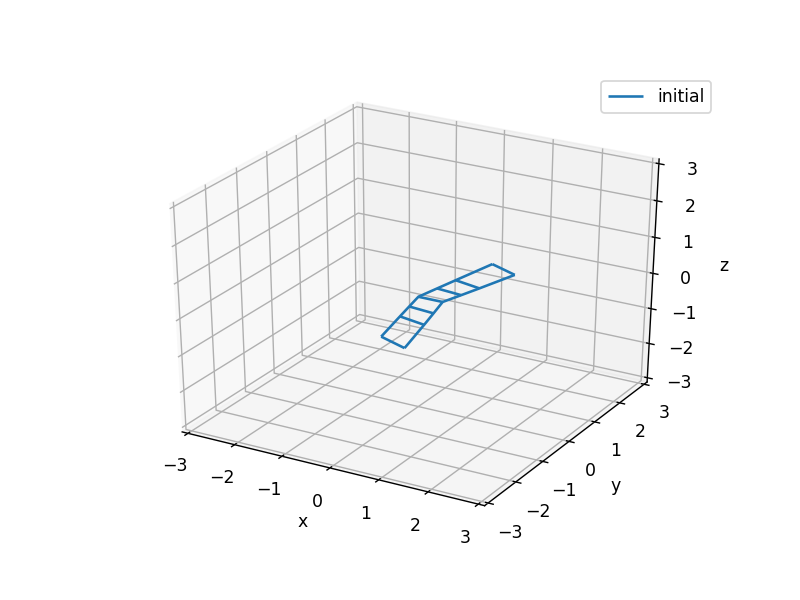

In [20]:
model = om.Group()
model.add_subsystem('Rotate', Rotate(val=np.array([20, 10, 5, 0, 5, 10, 20]), mesh_shape=np.shape(mesh)))
#model.add_subsystem('Rotate', Rotate(val=np.array([20, 10, 5, 0, 5, 10, 20]), mesh_shape=np.shape(mesh), rotate_x=False))
#model.add_subsystem('Rotate', Rotate(val=np.array([20, 10, 5, 0, 5, 10, 20]), mesh_shape=np.shape(mesh), symmetry=True))

prob = om.Problem(model)
prob.setup()

prob.set_val('Rotate.in_mesh', mesh)
#prob.set_val('Rotate.in_mesh', mesh_sym)

prob.run_model()
print(prob['Rotate.mesh'])

print(prob.get_val('Rotate.mesh'))
plotmesh(prob.get_val('Rotate.mesh'))

7/ Implement and test the Dihedral_distrib class (it allows to use a dihedral angle distribution):

In [25]:
class Dihedral_distrib(om.ExplicitComponent):
    """
    OpenMDAO component that manipulates the mesh by applying dihedral angles to the panels of the wing 
    (different to the Dihedral class in the sense that we can apply different dihedral angles to the panels 
    of the wing and not only the same angle to all the wing). Positive angles up.

    Parameters
    ----------
    mesh[nx, ny, 3] : numpy array
        Nodal mesh defining the initial aerodynamic surface.
    dihedral_distrib[ny-1] : numpy array
        1-D array of dihedral angles each wing panel in degrees. 
        Note that the size is equal to ny-1 because we apply the angles to panels and not to nodes.
    symmetry : boolean
        Flag set to true if surface is reflected about y=0 plane.

    Returns
    -------
    mesh[nx, ny, 3] : numpy array
        Nodal mesh defining the aerodynamic surface with dihedral angles on each panels.
    """

    def initialize(self):
        """
        Declare options.
        """
        self.options.declare('val', desc='Initial value for dihedral_distrib.')
        self.options.declare('mesh_shape', desc='Tuple containing mesh shape (nx, ny).')
        self.options.declare('symmetry', default=False,
                             desc='Flag set to true if surface is reflected about y=0 plane.')

    def setup(self):
        mesh_shape = self.options['mesh_shape']
        val = self.options['val']
        symmetry = self.options['symmetry']

        self.add_input('dihedral_distrib', val=val, units='deg')
        self.add_input('in_mesh', shape=mesh_shape, units='m')

        self.add_output('mesh', shape=mesh_shape, units='m')

     
    def setup_partials(self):
        symmetry =  self.options['symmetry']
        mesh_shape = mesh_shape = self.options['mesh_shape']
        nx, ny, _ = mesh_shape
        
        if(symmetry):
            rows = np.array([]) 
            cols = np.array([]) 

            for i in range(nx):
                for k in range(int(ny-1)):
                    rows= np.concatenate((rows, 3*np.arange(int(i*ny),int(i*ny + (ny-1) -k)) +2)) # add the position of the z coord of the points of the i-th edge
                    cols= np.concatenate((cols, int((ny-1) -(1+k))*np.ones(int((ny-1) -k)))) # add the position of the dihedral angle of the panel which corresponds 

            self.declare_partials('mesh', 'dihedral_distrib', rows=rows, cols=cols)  

            nn = nx*ny*3
            # the diagonal elements of the d_mesh/d_in_mesh are jacobian matrix are non zero.
            rows = np.arange(nn)
            cols = np.arange(nn)

            for i in range(nx):
                for j in range(ny):
                    if (j < (ny-1)):
                        for k in range(j,int(ny)):
                            rows = np.concatenate((rows, np.array([i*ny*3 + j*3+2])))
                            cols = np.concatenate((cols, np.array([k*3+1])))

            self.declare_partials('mesh', 'in_mesh', rows=rows, cols=cols)    
        
        else:
            
            rows = np.array([]) 
            cols = np.array([]) 

            for i in range(nx):
                for k in range(int((ny-1)/2)):
                    rows= np.concatenate((rows, 3*np.arange(int(i*ny),int(i*ny + ((ny-1)/2) -k)) +2)) # add the position of the z coord of the points of the left part of the i-th edge
                    rows= np.concatenate((rows, 3*np.arange(int(i*ny + ((ny+1)/2) +k), int((i+1)*ny )) +2)) # add the position of the z coord of the points of the right part of the i-th edge
                    cols= np.concatenate((cols, int(((ny-1)/2) -(1+k))*np.ones(int(((ny-1)/2) -k)))) # add the position of the dihedral angle of the panel which corresponds
                    cols= np.concatenate((cols, int(((ny-1)/2) +k)*np.ones(int(((ny-1)/2) -k))))

            self.declare_partials('mesh', 'dihedral_distrib', rows=rows, cols=cols)  

            nn = nx*ny*3
            # the diagonal elements of the d_mesh/d_in_mesh are jacobian matrix are non zero.
            rows = np.arange(nn)
            cols = np.arange(nn)

            for i in range(nx):
                for j in range(ny):
                    if (j < (ny-1)/2):
                        for k in range(j,int((ny+1)/2)):
                            rows = np.concatenate((rows, np.array([i*ny*3 + j*3+2])))
                            cols = np.concatenate((cols, np.array([k*3+1])))
                    if (j > (ny-1)/2):
                        for k in range(int((ny-1)/2), j+1):
                            rows = np.concatenate((rows, np.array([i*ny*3 + j*3+2])))
                            cols = np.concatenate((cols, np.array([k*3+1])))

            self.declare_partials('mesh', 'in_mesh', rows=rows, cols=cols) 
        
        
        
    def compute(self, inputs, outputs):        
        # #######################################################################
        # # save the differences in altitude caused by the wing twist 
        # #(we need to save these differences in order to not overwrite the data introducing 
        # #a dihedral angle distribution).
        # save_twist =  np.zeros((nx,ny))
        # no_twist_alt = (mesh[0,:,2] + mesh[-1,:,2])/2
        # for i in range(nx):
        #     save_twist[i,:] = mesh[i,:,2] - no_twist_alt
        
        # # set the z coordinates of the points of the leading edge (no wing twist for now):
        # le_slope_z_distrib = np.tan(dihedral_angle_distrib) # leading edge slope (z versus y)(around x axis)
        # for j in range(int(ny-1)):
        #     spanwise_dist = np.abs(mesh[0, j, 1] - mesh[0, j+1, 1])
        # spanwise_alt_dihedral_without_central_point = le_slope_z_distrib*spanwise_dist
        # for j in range(int((ny-1)/2)):
        #     spanwise_alt_dihedral_without_central_point[j] = np.sum(spanwise_alt_dihedral_without_central_point[j:int((ny-1)/2)])
        #     spanwise_alt_dihedral_without_central_point[-(j+1)] = np.sum(spanwise_alt_dihedral_without_central_point[::-1][j:int((ny-1)/2)])
        # spanwise_alt_with_central_point = np.zeros(ny)
        # spanwise_alt_with_central_point[:int((ny-1)/2)] += spanwise_alt_dihedral_without_central_point[:int((ny-1)/2)]
        # spanwise_alt_with_central_point[int((ny-1)/2)+1:] += spanwise_alt_dihedral_without_central_point[int((ny-1)/2):]
        # mesh[0, :, 2] = spanwise_alt_with_central_point
            
        # # set the z coordinates of all the other points of the mesh (no wing twist -> the z coordinate 
        # #depends only on the y coordinate, if there was wing twist it will also depends on the
        # #x coordinate):
        # for j in range(nx):
        #     mesh[j, :, 2] = mesh[0, :, 2] + save_twist[j,:]
            
        #######################################################################
        symmetry = self.options['symmetry']
        dihedral_angle_distrib = inputs['dihedral_distrib']
        mesh = inputs['in_mesh']

        # Get the mesh parameters and desired sweep angle
        nx, ny, _ = mesh.shape
        p180 = np.pi / 180
        dihedral_distrib_rad = p180 * dihedral_angle_distrib
        
        if(symmetry):
            # set the z coordinates of the points of the leading edge (no wing twist for now):
            le_slope_z_distrib = np.tan(dihedral_distrib_rad) # leading edge slope (z versus y)(around x axis)
            spanwise_dist = np.zeros(np.shape(le_slope_z_distrib))
            for j in range(int(ny-1)):
                spanwise_dist[j] = np.abs(mesh[0, j, 1] - mesh[0, j+1, 1])
            spanwise_alt_dihedral_without_central_point = le_slope_z_distrib*spanwise_dist
            for j in range(int(ny-1)):
                spanwise_alt_dihedral_without_central_point[j] = np.sum(spanwise_alt_dihedral_without_central_point[j:int(ny-1)])
            spanwise_alt_with_central_point = np.zeros(ny)
            spanwise_alt_with_central_point[:int(ny-1)] += spanwise_alt_dihedral_without_central_point[:int(ny-1)]
        else:
            # set the z coordinates of the points of the leading edge (no wing twist for now):
            le_slope_z_distrib = np.tan(dihedral_distrib_rad) # leading edge slope (z versus y)(around x axis)
            spanwise_dist = np.zeros(len(le_slope_z_distrib))
            for j in range(int(ny-1)):
                spanwise_dist[j] = np.abs(mesh[0, j, 1] - mesh[0, j+1, 1])
            spanwise_alt_dihedral_without_central_point = le_slope_z_distrib*spanwise_dist
            for j in range(int((ny-1)/2)):
                spanwise_alt_dihedral_without_central_point[j] = np.sum(spanwise_alt_dihedral_without_central_point[j:int((ny-1)/2)])
                spanwise_alt_dihedral_without_central_point[-(j+1)] = np.sum(spanwise_alt_dihedral_without_central_point[::-1][j:int((ny-1)/2)])
            spanwise_alt_with_central_point = np.zeros(ny)
            spanwise_alt_with_central_point[:int((ny-1)/2)] += spanwise_alt_dihedral_without_central_point[:int((ny-1)/2)]
            spanwise_alt_with_central_point[int((ny-1)/2)+1:] += spanwise_alt_dihedral_without_central_point[int((ny-1)/2):]
            
            
        outputs['mesh'][:] = mesh    
        for j in range(nx):
            outputs['mesh'][j, :, 2] += spanwise_alt_with_central_point
                
    def compute_partials(self, inputs, partials):
        symmetry = self.options['symmetry']
        dihedral_angle_distrib = inputs['dihedral_distrib']
        mesh = inputs['in_mesh']

        nx, ny, _ = mesh.shape
        p180 = np.pi / 180 # to pass in radians
        tan_dihedral_distrib = np.tan(p180 * dihedral_angle_distrib)
        dtan_ddihedral_angle_distrib = p180 / np.cos(p180*dihedral_angle_distrib)**2 

        mesh_y_diff = mesh[0,1:,1] - mesh[0,:-1,1]
        temp = mesh_y_diff * dtan_ddihedral_angle_distrib

        if symmetry :
            one_edge_ddihedral = np.array([])
            for k in range(ny-1):
                one_edge_ddihedral = np.concatenate((one_edge_ddihedral, temp[ny-1 - (1+k)]*np.ones(ny-1 - k)))

            partials['mesh', 'dihedral_distrib'][:] = np.tile(one_edge_ddihedral, nx) 
            print("partials['mesh', 'dihedral_distrib'] =",partials['mesh', 'dihedral_distrib'])

            nn = nx * ny * 3
            partials['mesh', 'in_mesh'][:nn] = np.ones(nn)

            one_edge_din_mesh = np.array([])

            for j in range(ny-1): # fill one_edge_din_mesh
                v = np.zeros(ny-1 +1 -j)
                for k in range(j, ny-1):
                    v[k - j] += -tan_dihedral_distrib[k]
                    v[k+1 -j] += tan_dihedral_distrib[k]
                one_edge_din_mesh = np.concatenate((one_edge_din_mesh, v))

            partials['mesh', 'in_mesh'][nn:] = np.tile(one_edge_din_mesh, nx)
            print("partials['mesh', 'in_mesh'] =",partials['mesh', 'in_mesh'])


        else:
            one_edge_ddihedral = np.array([])
            for k in range(int((ny-1)/2)):
                one_edge_ddihedral = np.concatenate((one_edge_ddihedral, temp[int((ny-1)/2) - (1+k)]*np.ones(int((ny-1)/2) - k)))
                one_edge_ddihedral = np.concatenate((one_edge_ddihedral, temp[int((ny-1)/2) + k]*np.ones(int((ny-1)/2) - k)))

            partials['mesh', 'dihedral_distrib'][:] = np.tile(one_edge_ddihedral, nx) 
            print("partials['mesh', 'dihedral_distrib'] =",partials['mesh', 'dihedral_distrib'])


            nn = nx * ny * 3
            partials['mesh', 'in_mesh'][:nn] = np.ones(nn)

            one_edge_din_mesh_left = np.array([])
            one_edge_din_mesh_right = np.array([])

            for j in range(int((ny-1)/2)): # fill the left part of one_edge_din_mesh
                v_left = np.zeros(int((ny-1)/2) +1 -j)
                for k in range(j, int((ny-1)/2)):
                    v_left[k - j] += -tan_dihedral_distrib[k]
                    v_left[k+1 -j] += tan_dihedral_distrib[k]
                one_edge_din_mesh_left = np.concatenate((one_edge_din_mesh_left, v_left))
            for j in range(int((ny-1)/2) +1, ny): # fill the right part of one_edge_din_mesh
                v_right = np.zeros(j + 1 - int((ny-1)/2))
                for k in range(int((ny-1)/2), j):
                    v_right[k - int((ny-1)/2)] += -tan_dihedral_distrib[k]
                    v_right[k+1 - int((ny-1)/2)] += tan_dihedral_distrib[k]
                one_edge_din_mesh_right = np.concatenate((one_edge_din_mesh_right, v_right))

            one_edge_din_mesh = np.array([])
            one_edge_din_mesh = np.concatenate((one_edge_din_mesh_left, one_edge_din_mesh_right))

            partials['mesh', 'in_mesh'][nn:] = np.tile(one_edge_din_mesh, nx)
            print("partials['mesh', 'in_mesh'] =",partials['mesh', 'in_mesh'])

    



Check that the mesh is well modified using the class Dihedral_distrib

[[[ 0.4        -2.          0.70925809]
  [ 0.2        -1.          0.13190782]
  [ 0.1        -0.5         0.04374433]
  [ 0.          0.          0.        ]
  [ 0.1         0.5         0.04374433]
  [ 0.2         1.          0.13190782]
  [ 0.4         2.          0.70925809]]

 [[ 0.9        -2.          0.70925809]
  [ 0.7        -1.          0.13190782]
  [ 0.6        -0.5         0.04374433]
  [ 0.5         0.          0.        ]
  [ 0.6         0.5         0.04374433]
  [ 0.7         1.          0.13190782]
  [ 0.9         2.          0.70925809]]]


<IPython.core.display.Javascript object>


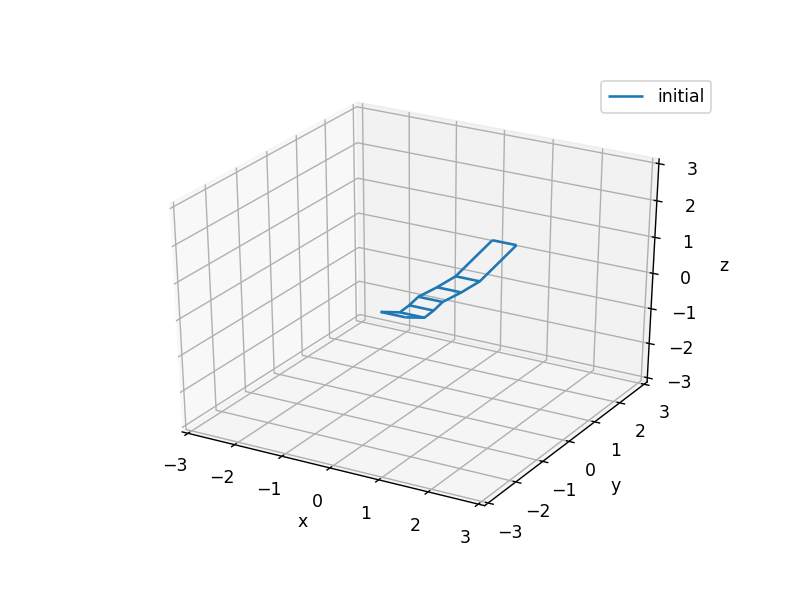

In [26]:
model = om.Group()
model.add_subsystem('Dihedral_distrib', Dihedral_distrib(val=np.array([30, 10, 5, 5, 10, 30]), mesh_shape=np.shape(mesh), symmetry = False))
#model.add_subsystem('Dihedral_distrib', Dihedral_distrib(val=np.array([30, 10, 5]), mesh_shape=np.shape(mesh_sym), symmetry = True))

prob = om.Problem(model)
prob.setup()

prob.set_val('Dihedral_distrib.in_mesh', mesh)
#prob.set_val('Dihedral_distrib.in_mesh', mesh_sym)


prob.run_model()

print(prob.get_val('Dihedral_distrib.mesh'))
plotmesh(prob.get_val('Dihedral_distrib.mesh'))

Check that the partial derivatives are correct

In [27]:
prob.check_partials(compact_print=True, show_only_incorrect=True)

partials['mesh', 'dihedral_distrib'] = [0.00879344 0.00879344 0.00879344 0.00879344 0.00879344 0.00879344
 0.00899797 0.00899797 0.00899797 0.00899797 0.02327106 0.02327106
 0.00879344 0.00879344 0.00879344 0.00879344 0.00879344 0.00879344
 0.00899797 0.00899797 0.00899797 0.00899797 0.02327106 0.02327106]
partials['mesh', 'in_mesh'] = [ 1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
 -0.57735027  0.40102329  0.08883832  0.08748866 -0.17632698  0.08883832
  0.08748866 -0.08748866  0.08748866 -0.08748866  0.08748866 -0.08748866
 -0.08883832  0.17632698 -0.08748866 -0.08883832 -0.40102329 

{'Dihedral_distrib': {('mesh',
   'dihedral_distrib'): {'J_fwd': array([[0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        ],
          [0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        ],
          [0.02327106, 0.00899797, 0.00879344, 0.        , 0.        ,
           0.        ],
          [0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        ],
          [0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        ],
          [0.        , 0.00899797, 0.00879344, 0.        , 0.        ,
           0.        ],
          [0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        ],
          [0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        ],
          [0.        , 0.        , 0.00879344, 0.        , 0.        ,
           0.        ],
          [0.        , 0.        , 0.        , 0.        , 0.        ,
           0

In [28]:
data = prob.check_partials(compact_print=True)
print(data)

partials['mesh', 'dihedral_distrib'] = [0.00879344 0.00879344 0.00879344 0.00879344 0.00879344 0.00879344
 0.00899797 0.00899797 0.00899797 0.00899797 0.02327106 0.02327106
 0.00879344 0.00879344 0.00879344 0.00879344 0.00879344 0.00879344
 0.00899797 0.00899797 0.00899797 0.00899797 0.02327106 0.02327106]
partials['mesh', 'in_mesh'] = [ 1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
 -0.57735027  0.40102329  0.08883832  0.08748866 -0.17632698  0.08883832
  0.08748866 -0.08748866  0.08748866 -0.08748866  0.08748866 -0.08748866
 -0.08883832  0.17632698 -0.08748866 -0.08883832 -0.40102329 